# Primera ejecución

Para esta primera ejecución se hará lo siguiente:

- Se tendrá más de 100 asignaciones (más de 8000 pinturas)
- Se tendrá la división: 
    - 80% para entrenamiento
    - 20% para testeo

Librerías que usaremos

In [ ]:
import os
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

2024-12-08 00:08:49.008157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
Estos serán nuestros hiperparámetros

In [ ]:
IMG_HEIGHT  = 300
IMG_WIDTH   = 300
BATCH_SIZE  = 32
EPOCHS      = 20
SEED        = 1234
CONV        = 3 #Este es el tamaño del filtro del kernel
strPath     = "./images"

Ahora creamos los sets de entrenamiento y validación

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  strPath,
  validation_split = 0.2,
  subset     = "training",
  seed       = SEED,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE)

Found 8774 files belonging to 51 classes.
Using 7020 files for training.


2024-12-08 00:09:01.006183: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  strPath,
  validation_split = 0.2,
  subset     = "validation",
  seed       = SEED,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE)

Found 8774 files belonging to 51 classes.
Using 1754 files for validation.


Como se dijo anteriormente, no es necesario hacer un one-hot-encoder, ya que TensoFlow detecta automáticamente las clases de acuerdo a las carpetas.

In [ ]:
class_names = train_ds.class_names

num_classes = len(class_names)

print(class_names)

['Albrecht_Dürer', 'Albrecht_Du╠êrer', 'Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez', 'Edgar_Degas', 'Edouard_Manet', 'Edvard_Munch', 'El_Greco', 'Eugene_Delacroix', 'Francisco_Goya', 'Frida_Kahlo', 'Georges_Seurat', 'Giotto_di_Bondone', 'Gustav_Klimt', 'Gustave_Courbet', 'Henri_Matisse', 'Henri_Rousseau', 'Henri_de_Toulouse-Lautrec', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Jan_van_Eyck', 'Joan_Miro', 'Kazimir_Malevich', 'Leonardo_da_Vinci', 'Marc_Chagall', 'Michelangelo', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Paul_Cezanne', 'Paul_Gauguin', 'Paul_Klee', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Piet_Mondrian', 'Pieter_Bruegel', 'Raphael', 'Rembrandt', 'Rene_Magritte', 'Salvador_Dali', 'Sandro_Botticelli', 'Titian', 'Vasiliy_Kandinskiy', 'Vincent_van_Gogh', 'William_Turner']


Veremos algunas pinturas para ver como está nuestro set de entrenamiento.

2024-12-08 00:09:02.807802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7020]
	 [[{{node Placeholder/_0}}]]
2024-12-08 00:09:02.808190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7020]
	 [[{{node Placeholder/_4}}]]


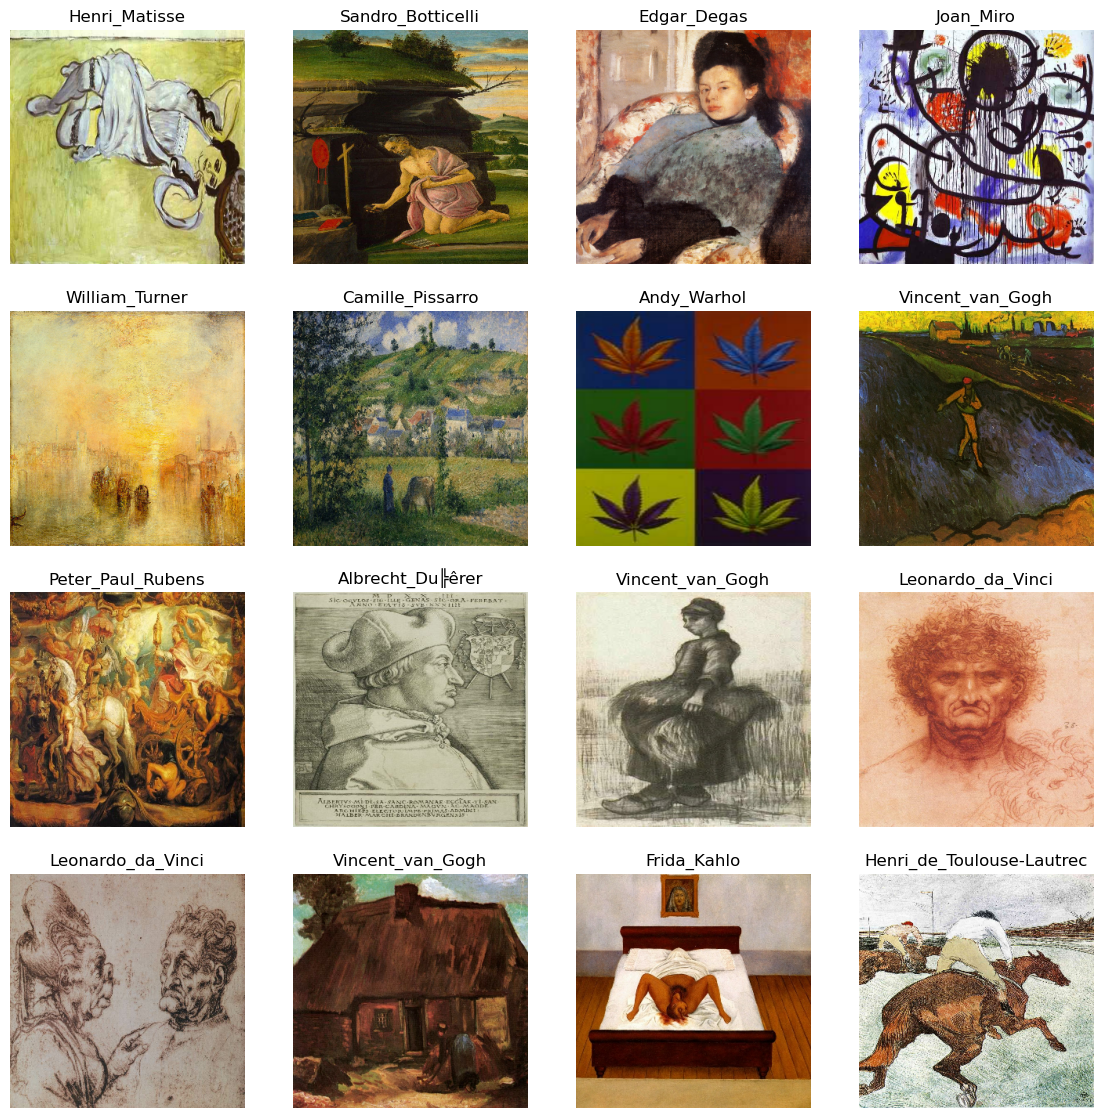

In [8]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Ahora veremos las formas y las etiquetas de un valor cualquiera del dataset

In [ ]:
image_batch, labels_batch = train_ds.take(1):
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Label batch shape: {labels_batch.shape}")

2024-12-08 00:09:06.776544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7020]
	 [[{{node Placeholder/_4}}]]
2024-12-08 00:09:06.776758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7020]
	 [[{{node Placeholder/_4}}]]


(32, 300, 300, 3)
(32,)


El siguiente código se usa para la mezcla de dastos y optimización en memoría:

- `.shuffle`: Esto mezcla el orden de los datos en el conjunto de datos de entrenamiento. La mezcla aleatoria ayuda a evitar entrenar el modelo con datos que se presentan en un orden específico, lo que genera un modelo más sólido. El argumento 1000 especifica el tamaño del búfer utilizado para la mezcla.

- `.prefetch(buffer_size=AUTOTUNE)`: esto captura previamente una cierta cantidad de lotes de datos del conjunto de datos de entrenamiento por adelantado. Esto ayuda a ocultar la latencia de la carga y el procesamiento de datos del ciclo de entrenamiento, lo que potencialmente mejora la velocidad del entrenamiento.

Es importante destacar que aquí `buffer_size` está configurado en `AUTOTUNE`. Esto le indica a TensorFlow que determine automáticamente el tamaño de búfer óptimo para la captación previa en función de las características de su hardware y conjunto de datos.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
Capa para normalizar datos de [0.1]

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Data augmentation: Es código realiza transformaciones sobre las imágenes con el objetivo de aumentar datos sin comprometer su escencia.

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomZoom(0.2), 
    layers.experimental.preprocessing.RandomTranslation(0.3,0.2), 
    layers.experimental.preprocessing.RandomContrast(0.2)
  ]
)

Ahora podremos ver los datos generados a partir del anterior código 

In [13]:
plt.figure(figsize=(14, 14))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

2024-12-08 00:09:07.351321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7020]
	 [[{{node Placeholder/_0}}]]
2024-12-08 00:09:07.351587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7020]
	 [[{{node Placeholder/_0}}]]
2024-12-08 00:09:17.361275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 42 of 1000
2024-12-08 00:09:27.493422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 81 of 1000
2024-12-08 00:09

KeyboardInterrupt: 

<Figure size 1400x1400 with 0 Axes>

Creamos el modelo con las capas ya mencionadas.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, CONV, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, CONV, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, CONV, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

Inicialización de las funciones de pérdida y optimizadores.

In [ ]:
opti = tf.keras.optimizers.RMSprop(momentum=0.1) 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

Compilamos el modelo

In [ ]:
model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

Sacamos las estadísticas del entrenamiento (pérdida) y empezamos el entrenamiento con los datos ya datos

In [ ]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs          = EPOCHS
)

Epoch 1/20
202/220 [==========================>...] - ETA: 15s - loss: 3.5107 - accuracy: 0.1307

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - ETA: 0s - loss: 3.4978 - accuracy: 0.1335

2024-12-06 17:03:21.012551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1754]
	 [[{{node Placeholder/_4}}]]
2024-12-06 17:03:21.013033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1754]
	 [[{{node Placeholder/_4}}]]


220/220 [==============================] - 209s 929ms/step - loss: 3.4978 - accuracy: 0.1335 - val_loss: 3.2269 - val_accuracy: 0.1722
Epoch 2/20
202/220 [==========================>...] - ETA: 15s - loss: 3.1502 - accuracy: 0.1793

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 196s 886ms/step - loss: 3.1469 - accuracy: 0.1816 - val_loss: 3.4601 - val_accuracy: 0.1596
Epoch 3/20
202/220 [==========================>...] - ETA: 14s - loss: 3.0133 - accuracy: 0.2059

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 187s 849ms/step - loss: 3.0117 - accuracy: 0.2058 - val_loss: 3.4049 - val_accuracy: 0.1881
Epoch 4/20
202/220 [==========================>...] - ETA: 14s - loss: 2.8978 - accuracy: 0.2324

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 188s 852ms/step - loss: 2.8962 - accuracy: 0.2343 - val_loss: 3.1011 - val_accuracy: 0.2258
Epoch 5/20
202/220 [==========================>...] - ETA: 15s - loss: 2.8416 - accuracy: 0.2322

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 200s 910ms/step - loss: 2.8399 - accuracy: 0.2330 - val_loss: 3.3975 - val_accuracy: 0.1784
Epoch 6/20
202/220 [==========================>...] - ETA: 14s - loss: 2.7777 - accuracy: 0.2536

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 192s 869ms/step - loss: 2.7766 - accuracy: 0.2547 - val_loss: 2.8086 - val_accuracy: 0.2480
Epoch 7/20
202/220 [==========================>...] - ETA: 14s - loss: 2.7433 - accuracy: 0.2573

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 192s 869ms/step - loss: 2.7390 - accuracy: 0.2593 - val_loss: 2.8803 - val_accuracy: 0.2554
Epoch 8/20
202/220 [==========================>...] - ETA: 14s - loss: 2.6910 - accuracy: 0.2718

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 188s 855ms/step - loss: 2.6905 - accuracy: 0.2736 - val_loss: 2.9714 - val_accuracy: 0.2480
Epoch 9/20
202/220 [==========================>...] - ETA: 14s - loss: 2.6439 - accuracy: 0.2761

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 189s 860ms/step - loss: 2.6468 - accuracy: 0.2796 - val_loss: 2.9787 - val_accuracy: 0.2349
Epoch 10/20
202/220 [==========================>...] - ETA: 14s - loss: 2.6084 - accuracy: 0.2899

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 197s 892ms/step - loss: 2.6129 - accuracy: 0.2913 - val_loss: 3.0315 - val_accuracy: 0.2081
Epoch 11/20
202/220 [==========================>...] - ETA: 13s - loss: 2.5726 - accuracy: 0.2956

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 184s 820ms/step - loss: 2.5778 - accuracy: 0.2972 - val_loss: 2.7935 - val_accuracy: 0.2628
Epoch 12/20
202/220 [==========================>...] - ETA: 13s - loss: 2.5494 - accuracy: 0.3072

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 175s 796ms/step - loss: 2.5466 - accuracy: 0.3107 - val_loss: 3.5869 - val_accuracy: 0.1796
Epoch 13/20
202/220 [==========================>...] - ETA: 13s - loss: 2.5312 - accuracy: 0.3093

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 177s 804ms/step - loss: 2.5286 - accuracy: 0.3107 - val_loss: 3.4958 - val_accuracy: 0.2087
Epoch 14/20
202/220 [==========================>...] - ETA: 13s - loss: 2.4923 - accuracy: 0.3170

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 176s 800ms/step - loss: 2.4883 - accuracy: 0.3174 - val_loss: 2.6459 - val_accuracy: 0.2948
Epoch 15/20
202/220 [==========================>...] - ETA: 13s - loss: 2.4510 - accuracy: 0.3303

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 177s 803ms/step - loss: 2.4501 - accuracy: 0.3308 - val_loss: 3.6255 - val_accuracy: 0.1881
Epoch 16/20
202/220 [==========================>...] - ETA: 13s - loss: 2.4449 - accuracy: 0.3286

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 177s 802ms/step - loss: 2.4468 - accuracy: 0.3293 - val_loss: 2.5491 - val_accuracy: 0.3010
Epoch 17/20
202/220 [==========================>...] - ETA: 13s - loss: 2.4258 - accuracy: 0.3278

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 177s 802ms/step - loss: 2.4271 - accuracy: 0.3271 - val_loss: 3.1658 - val_accuracy: 0.2372
Epoch 18/20
202/220 [==========================>...] - ETA: 13s - loss: 2.3909 - accuracy: 0.3321

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 178s 810ms/step - loss: 2.3899 - accuracy: 0.3338 - val_loss: 4.5700 - val_accuracy: 0.1722
Epoch 19/20
202/220 [==========================>...] - ETA: 13s - loss: 2.3930 - accuracy: 0.3379

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 173s 785ms/step - loss: 2.3906 - accuracy: 0.3387 - val_loss: 2.7066 - val_accuracy: 0.2902
Epoch 20/20
202/220 [==========================>...] - ETA: 13s - loss: 2.3657 - accuracy: 0.3393

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


220/220 [==============================] - 175s 796ms/step - loss: 2.3696 - accuracy: 0.3425 - val_loss: 2.6160 - val_accuracy: 0.3005


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

Ahora graficaremos la función de pérdida y la presición (`accuracy`)

In [ ]:
# Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Accuracy Over Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Loss Over Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


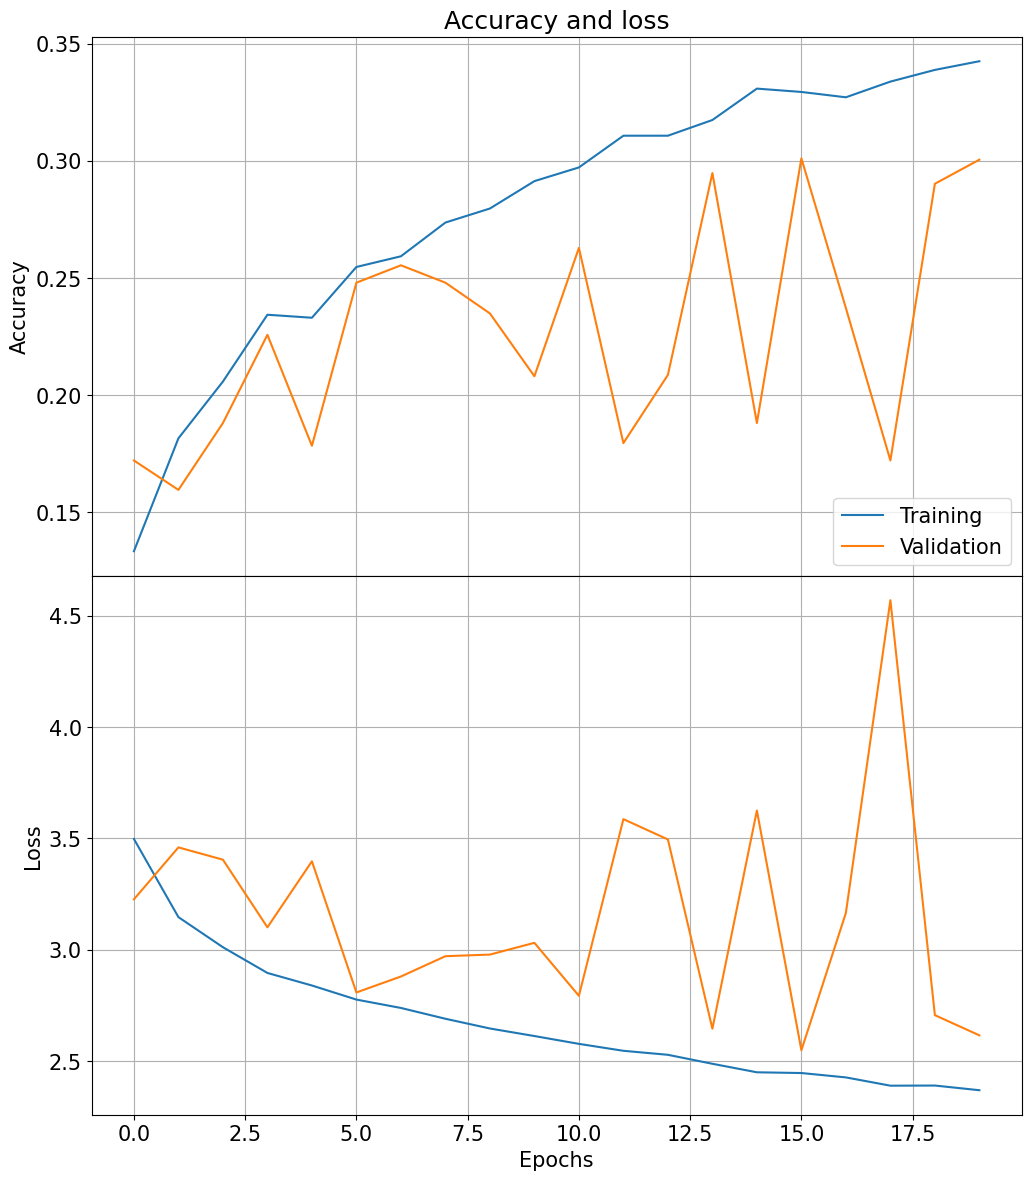

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(12, 14))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Accuracy and loss')
plt.ylabel("Accuracy")
plt.grid(True)

ax1 = plt.subplot(gs[1], sharex = ax0)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid(True)

plt.subplots_adjust(hspace=.0)
plt.show()

In [ ]:

epochs_range = range(EPOCHS)

plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(12, 14))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Accuracy and loss')
plt.ylabel("Accuracy")
plt.grid(True)

ax1 = plt.subplot(gs[1], sharex = ax0)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid(True)

plt.subplots_adjust(hspace=.0)
plt.show()

Ahora graficaremos la matriz de confusión la cual nos indica que tan bueno es nuestro modelo.

In [ ]:
def truncate_labels(labels, max_length=10):
    return [label[:max_length] + "..." if len(label) > max_length else label for label in labels]

y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

truncated_class_names = truncate_labels(class_names, max_length=10)

1/1 [==============================] - 0s 92ms/step


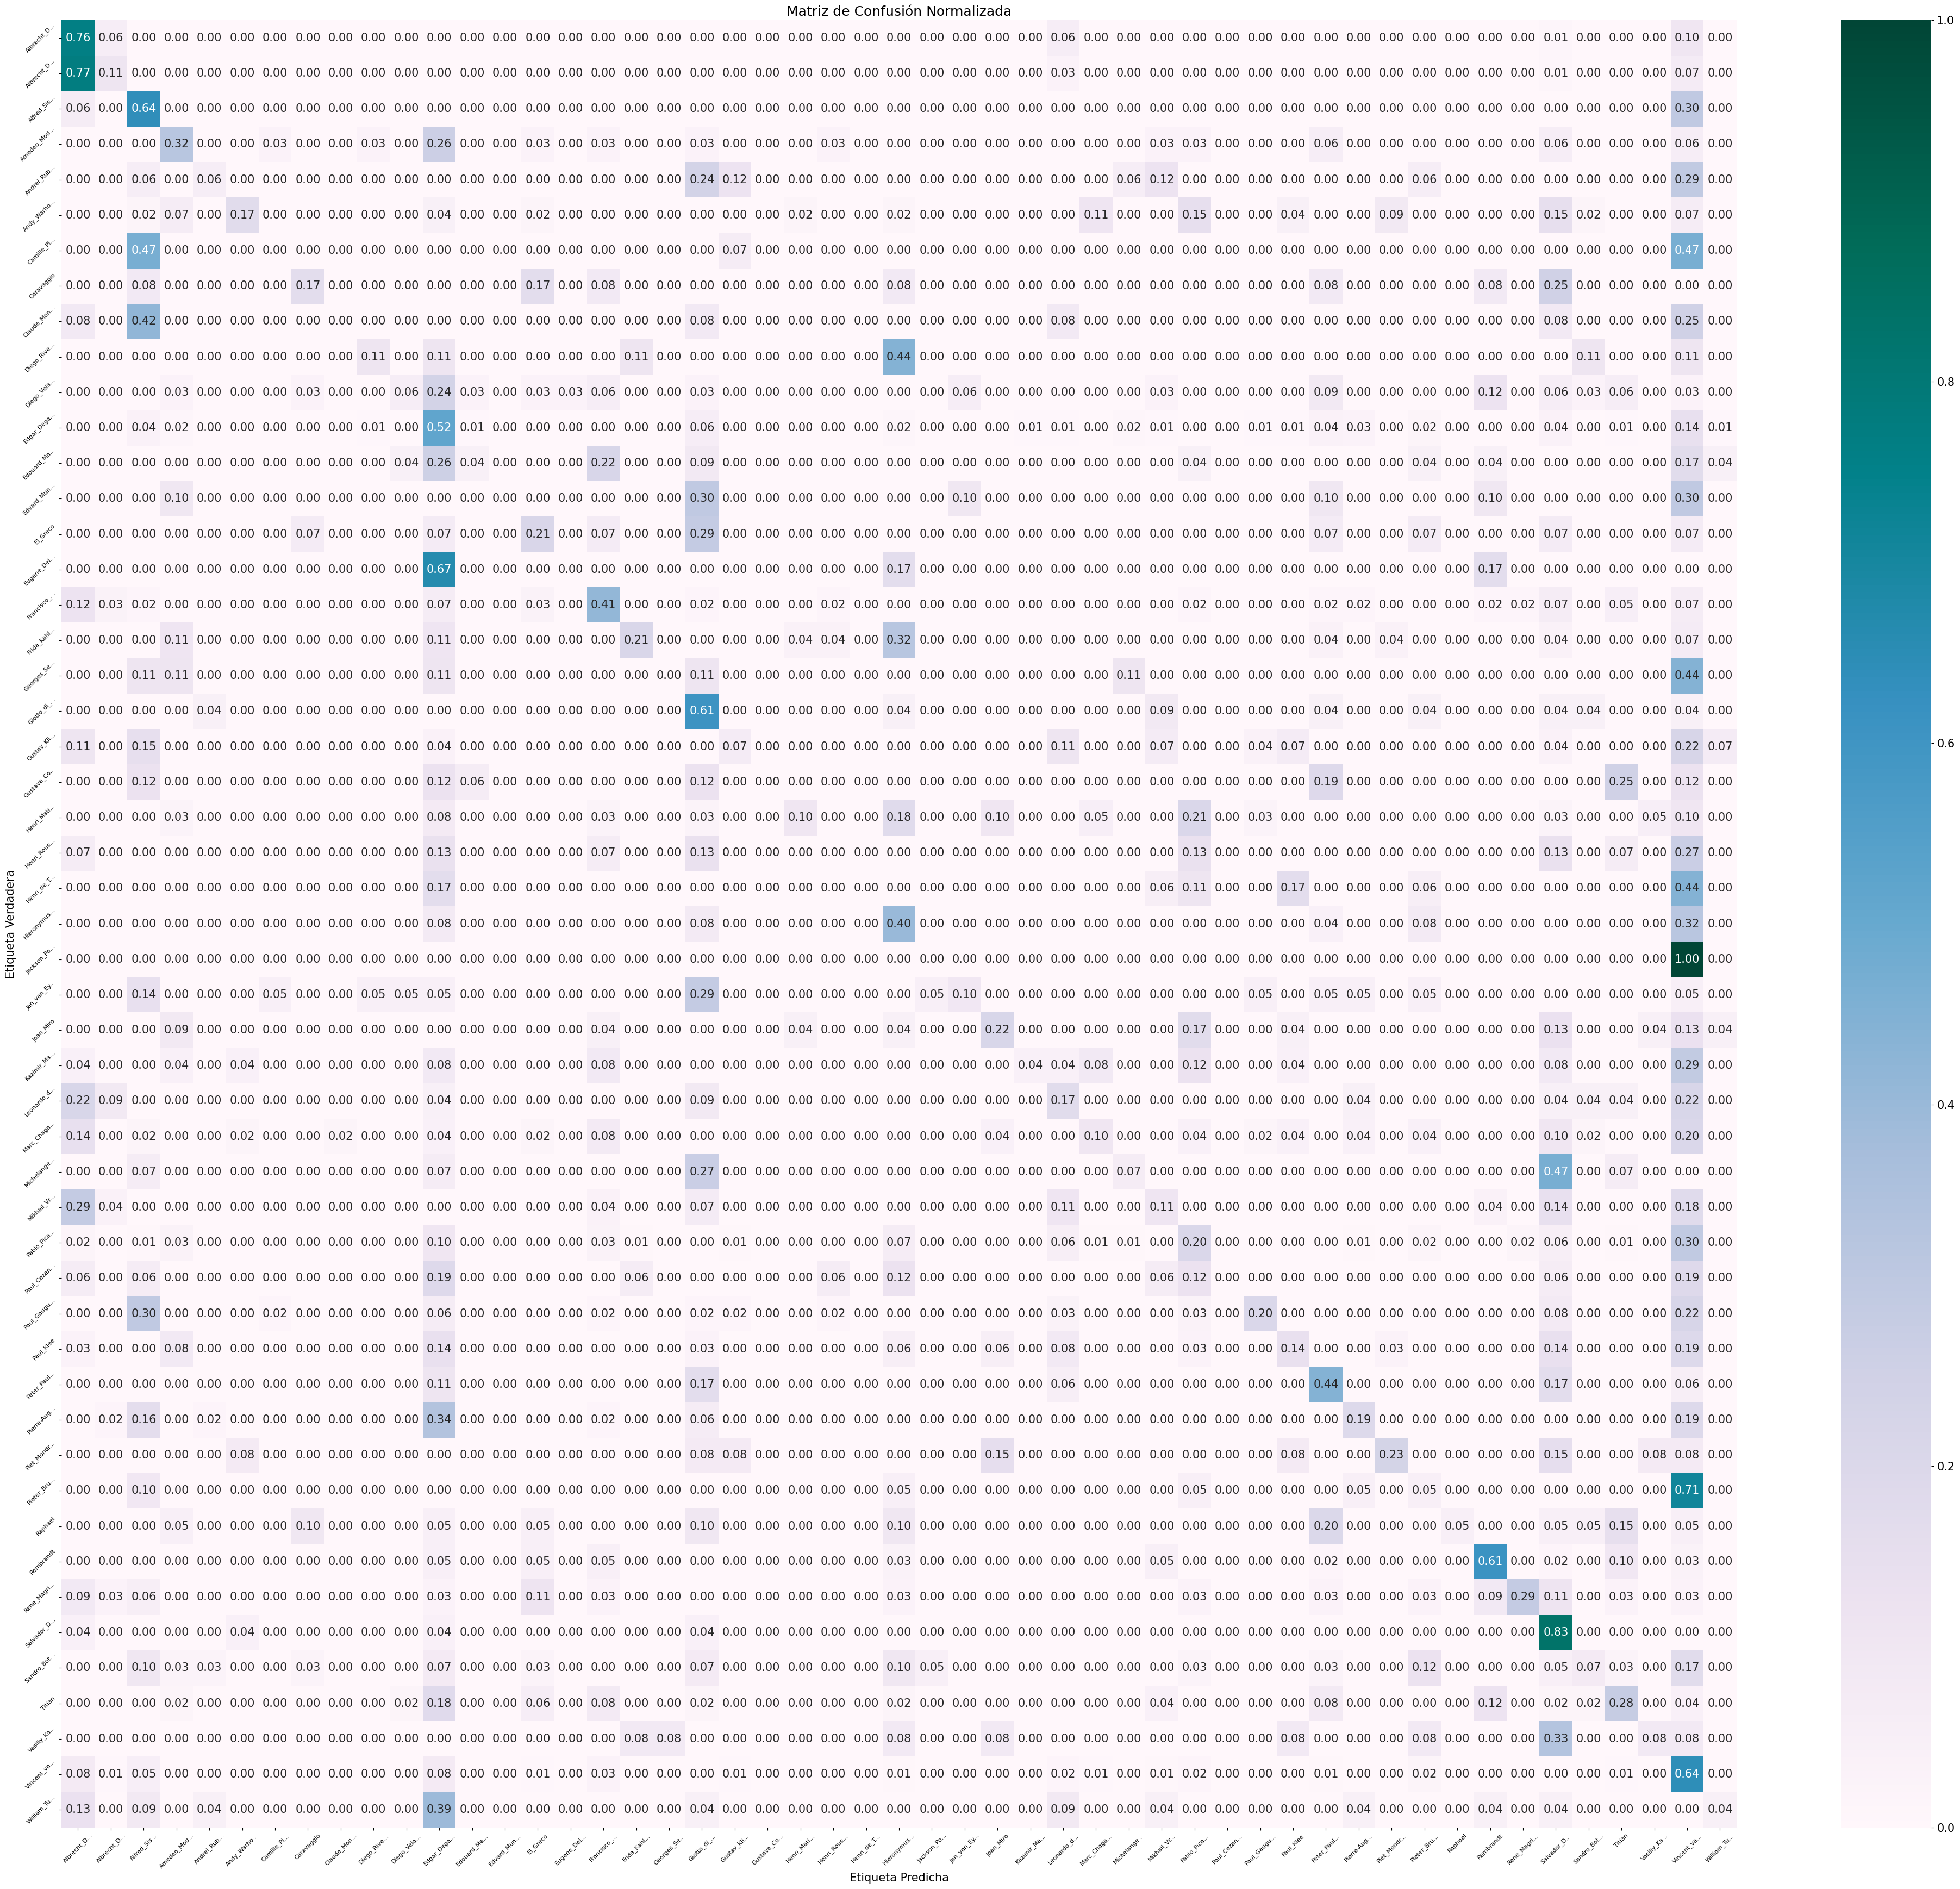

In [ ]:
plt.figure(figsize=(40,35))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="PuBuGn",
            xticklabels=truncated_class_names, yticklabels=truncated_class_names)

plt.title("Matriz de Confusión Normalizada")
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


Media de la confiabilidad

In [ ]:
mean_acc = np.mean(acc)
mean_val_acc = np.mean(val_acc)

print(f"Media de confiabilidad (entrenamiento): {mean_acc:.2f}")
print(f"Media de confiabilidad (validación): {mean_val_acc:.2f}")

Mediana de la confiabilidad

In [ ]:
median_train_accuracy = statistics.median(acc)
median_val_accuracy = statistics.median(val_acc)

print("Mediana de accuracy en entrenamiento:", median_train_accuracy)
print("Mediana de accuracy en validación:", median_val_accuracy)